In [1]:
%matplotlib inline

import os, sys, re
import pandas as pd
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
log_file_path = "C:/Users/AndrzejZuranski/tmp/qchem/gaussian/C12H16P_472c/C12H16P_472c_conf_0.log"

In [3]:
with open(log_file_path) as f:
    log = f.read()

In [4]:
# how many linebreaks
len(re.findall("\n", log))

22429

In [5]:
# fetch atom labels
def get_atom_labels(text):
    """fetch the z-matrix from the log file and save atom labels"""
    
    # regex logic, fetch part between "Multiplicity =\d\n" and a double line
    # break (empty line may contain spaces)
    z_matrix = re.findall("Multiplicity = \d\n(.*?)\n\s*\n", text, re.DOTALL)[0]
    labels = [items[0] for items in map(str.split, z_matrix.split("\n"))]
    return labels

get_atom_labels(log)

['C',
 'C',
 'C2',
 'C',
 'C',
 'C',
 'P1',
 'C3',
 'C',
 'C',
 'C',
 'C',
 'C',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H']

In [6]:
# split log into parts based on the gaussian jobs

# regex logic: log parts start with a new line and " # " pattern
log_parts = re.split("\n\s#\s", log)[1:]
parts = {}
for p in log_parts: 
    # regex logic: find first word in the text
    name = re.search("^\w+", p).group(0)
    parts[name] = p

In [7]:
def get_geometries(text):
    """fetch geometries from the log file"""
    
    # regex logic: find parts between "Standard orientation.*X Y Z" and "Rotational constants"
    geoms=re.findall("Standard orientation:.*?X\s+Y\s+Z\n(.*?)\n\s*Rotational constants", text, re.DOTALL)
    
    geom_dfs = []
    for geom in geoms:
        
        # split lines, strip them, filter out the lines with "----", split entries in each line
        geom = geom.splitlines()
        geom = map(str.strip, geom)
        geom = filter(lambda line: set(line) != {'-'}, geom)
        geom = map(str.split, geom)
        
        # convert to np.array for further manipulation (note: arrays have unique dtype, here it's str)
        geom_arr = np.array(list(geom))
        
        # create a dataframe
        geom_df = pd.concat([
            pd.DataFrame(geom_arr[:, 1:3].astype(int), columns=['AN', 'Type']),
            pd.DataFrame(geom_arr[:, 3:].astype(float), columns=list('XYZ'))
        ], axis=1)
        
        # add atom labels
        geom_df.insert(loc=0, column='Atom', value=get_atom_labels(log))
        # add this geometry to the list of geometries
        geom_dfs.append(geom_df)
        
    return geom_dfs

,Atom,AN,Type,X,Y,Z
0,C,6,0,-2.940947,1.573472,-0.579245
1,C,6,0,-1.731566,0.892839,-0.461910
2,C2,6,0,-1.686577,-0.434088,0.021199
3,C,6,0,-2.914591,-1.042715,0.375799
4,C,6,0,-4.121423,-0.361227,0.257896
5,C,6,0,-4.140674,0.952616,-0.220127
6,P1,15,0,-0.206649,-1.466456,0.220542
7,C3,6,0,1.221284,-0.317898,-0.207336
8,C,6,0,2.461882,-1.167102,-0.562234
9,C,6,0,3.679671,-0.287802,-0.890980


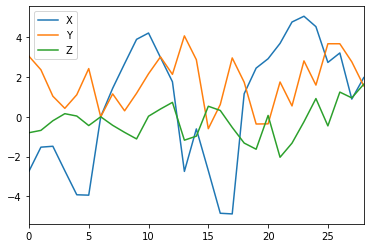

In [9]:
x = get_geometries(parts['opt'])
geo = x[26]
r = list('XYZ')
g = geo[r] - geo.loc[geo['AN'].idxmax(), r]
g.plot()
geo

In [214]:
# get the part of text with frequencies

# regex logic: text between "Harmonic... normal coordinates and Thermochemistry, preceeded by a line of "---"
freq_part = re.findall("Harmonic frequencies.*normal coordinates:\s*(\n.*?)\n\n\s*-+\n.*Thermochemistry", parts['freq'], re.DOTALL)[0]

In [217]:
# split off each section of text with frequencies

# regex logic, each frequency part ends with a \s\d+\n, note: we do not use DOTALL here!
freq_sections= re.split("\n.*?\s\d+\n", freq_part)[1:]

In [218]:
len(freq_sections)

27

In [219]:
def extract_frequencies(freq_section):
    """extract the frequency and other features for each mode within a text section"""
    
    freqs = re.findall("\n(\s\w+.*?)\n\s+Atom", freq_section, re.DOTALL)[0]
    freqs = freqs.split("\n")
    freqs = [text.split("--") for text in freqs]
    freqs = [[item[0].strip()] + item[1].split() for item in freqs]
    freqs = np.array(freqs).T.tolist()
    freqs_df = pd.DataFrame(freqs[1:], columns=freqs[0])
    return freqs_df

In [238]:
def extract_moment_vectors(freq_section):
    """extract moment vectors for each mode within a text section"""
    
    vectors = re.findall("\n(\s+Atom.*)", freq_section, re.DOTALL)[0]
    vectors = [text.split() for text in vectors.split("\n")]
    vectors_df = pd.DataFrame(vectors[1:], columns=vectors[0])
    vectors_df.drop(["Atom", "AN"], axis=1, inplace=True)
    return vectors_df

In [248]:
# combine frequencies
freqs = pd.concat(extract_frequencies(section) for section in freq_sections)
freqs['mode_number'] = range(1, len(freqs)+1)
freqs = freqs.set_index('mode_number')
freqs

,Frequencies,Red. masses,Frc consts,IR Inten,Dip. str.,Rot. str.,E-M angle
mode_number,,,,,,,
1,32.0203,4.3085,0.0026,0.2543,31.6848,-0.8573,97.0474
2,59.8684,3.3248,0.0070,0.0109,0.7287,-1.1697,125.1697
3,69.0108,3.7294,0.0105,0.0332,1.9208,-0.2043,95.5743
4,148.5955,3.2241,0.0419,0.4617,12.3958,2.9251,71.3674
5,165.3174,4.6803,0.0754,0.0335,0.8094,-2.6164,171.1405
...,...,...,...,...,...,...,...
77,3175.8817,1.0858,6.4527,2.8040,3.5222,0.3370,87.9401
78,3183.0131,1.0870,6.4889,0.6260,0.7846,0.1424,87.3549
79,3193.5702,1.0916,6.5594,19.8920,24.8490,-0.8353,90.6274


In [294]:
# combine moment vectors
vectors = pd.concat([extract_moment_vectors(section) for section in freq_sections], axis=1)
assert len(freqs) == len(vectors.columns)//3
vectors.columns = pd.MultiIndex.from_product([list(range(1, len(freqs)+1)), ['X', 'Y', 'Z'],])
vectors.columns.names=['mode_number', 'axis']
vectors.index = get_atom_labels(log)
vectors

mode_number     1                    2                    3                 \
axis             X      Y      Z      X      Y      Z      X      Y      Z   
C            -0.02   0.01   0.05   0.08   0.07   0.18  -0.14  -0.00   0.07   
C            -0.01   0.05   0.14   0.06   0.03   0.14  -0.10   0.06   0.03   
C2           -0.01   0.02   0.06   0.01  -0.03  -0.00  -0.03   0.04  -0.02   
C            -0.03  -0.05  -0.12  -0.02  -0.04  -0.14   0.01  -0.04  -0.04   
C            -0.04  -0.09  -0.22   0.00  -0.01  -0.11  -0.03  -0.11   0.00   
C            -0.04  -0.06  -0.14   0.05   0.05   0.05  -0.11  -0.09   0.06   
P1           -0.00   0.06   0.16  -0.01  -0.05  -0.01   0.01   0.10  -0.05   
C3           -0.01   0.04   0.08  -0.00  -0.06   0.00   0.02   0.08  -0.07   
C            -0.06   0.02  -0.05   0.03  -0.06   0.12  -0.01  -0.01   0.03   
C            -0.07   0.00  -0.13   0.01  -0.05   0.06   0.10  -0.14   0.10   
C             0.06  -0.05  -0.12  -0.05   0.09  -0.05   0.09  -0.13   0.10   
C             0.11  -0.03   0.01  -0.09   0.07  -0.15   0.13   0.00  -0.06   
C             0.11  -0.01   0.09  -0.05   0.04  -0.07   0.02   0.13  -0.11   
H            -0.02   0.04   0.12   0.12   0.12   0.30  -0.20   0.01   0.12   
H             0.01   0.11   0.29   0.08   0.04   0.23  -0.13   0.11   0.04   
H            -0.03  -0.07  -0.18  -0.06  -0.09  -0.26   0.07  -0.06  -0.08   
H            -0.06  -0.15  -0.36  -0.02  -0.02  -0.22  -0.00  -0.17  -0.01   
H            -0.05  -0.09  -0.22   0.07   0.09   0.08  -0.13  -0.13   0.09   
H            -0.07   0.08   0.12   0.02  -0.14  -0.06   0.06   0.04  -0.11   
H            -0.15   0.05  -0.05   0.08  -0.16   0.19  -0.00  -0.02   0.03   
H            -0.00  -0.01  -0.10   0.03   0.04   0.20  -0.13  -0.02   0.06   
H            -0.14   0.04  -0.09   0.02  -0.17  -0.01   0.23  -0.15   0.07   
H            -0.10  -0.01  -0.23   0.04  -0.05   0.16   0.06  -0.23   0.20   
H             0.05  -0.06  -0.17  -0.08   0.10  -0.12   0.18  -0.22   0.16   
H             0.12  -0.09  -0.17  -0.03   0.21   0.02  -0.06  -0.13   0.15   
H             0.05   0.01   0.06  -0.12  -0.03  -0.22   0.26  -0.03  -0.13   
H             0.20  -0.07   0.02  -0.13   0.17  -0.22   0.11   0.04  -0.08   
H             0.15   0.01   0.18  -0.08   0.02  -0.11   0.06   0.21  -0.21   
H             0.17  -0.04   0.05  -0.02   0.12  -0.03  -0.09   0.17  -0.06   

mode_number     4   ...     78     79                   80                \
axis             X  ...      Z      X      Y      Z      X      Y      Z   
C            -0.10  ...   0.02  -0.00  -0.04   0.01   0.00   0.01  -0.00   
C            -0.07  ...  -0.01   0.01   0.01  -0.00  -0.03  -0.02   0.01   
C2           -0.03  ...   0.00   0.00   0.00  -0.00   0.00   0.00  -0.00   
C            -0.00  ...  -0.01   0.00  -0.03   0.01   0.00  -0.02   0.01   
C            -0.02  ...   0.00  -0.05  -0.02   0.01  -0.04  -0.02   0.01   
C            -0.06  ...  -0.00   0.03  -0.02   0.00  -0.05   0.03  -0.01   
P1           -0.03  ...  -0.00   0.00  -0.00   0.00  -0.00  -0.00   0.00   
C3            0.06  ...  -0.00  -0.00   0.00  -0.00   0.00  -0.00   0.00   
C             0.05  ...   0.00  -0.00  -0.00   0.00  -0.00  -0.00  -0.00   
C            -0.00  ...   0.00  -0.00   0.00  -0.00   0.00  -0.00  -0.00   
C             0.06  ...   0.00   0.00  -0.00   0.00   0.00   0.00   0.00   
C             0.04  ...   0.00   0.00  -0.00   0.00   0.00   0.00   0.00   
C             0.11  ...   0.00  -0.00   0.00   0.00   0.00  -0.00  -0.00   
H            -0.14  ...  -0.26  -0.00   0.41  -0.15  -0.00  -0.12   0.04   
H            -0.09  ...   0.06  -0.18  -0.10   0.06   0.39   0.21  -0.12   
H             0.03  ...   0.15  -0.00   0.38  -0.14  -0.00   0.18  -0.07   
H             0.01  ...   0.00   0.55   0.29  -0.17   0.46   0.25  -0.14   
H            -0.07  ...   0.04  -0.37   0.21  -0.03   0.57  -0.33   0.06   
H             0.14  ...   0.01   0.00  -0.00   0.00  -0.00   

In [296]:
freqs

,Frequencies,Red. masses,Frc consts,IR Inten,Dip. str.,Rot. str.,E-M angle
mode_number,,,,,,,
1,32.0203,4.3085,0.0026,0.2543,31.6848,-0.8573,97.0474
2,59.8684,3.3248,0.0070,0.0109,0.7287,-1.1697,125.1697
3,69.0108,3.7294,0.0105,0.0332,1.9208,-0.2043,95.5743
4,148.5955,3.2241,0.0419,0.4617,12.3958,2.9251,71.3674
5,165.3174,4.6803,0.0754,0.0335,0.8094,-2.6164,171.1405
...,...,...,...,...,...,...,...
77,3175.8817,1.0858,6.4527,2.8040,3.5222,0.3370,87.9401
78,3183.0131,1.0870,6.4889,0.6260,0.7846,0.1424,87.3549
79,3193.5702,1.0916,6.5594,19.8920,24.8490,-0.8353,90.6274
